In [11]:
import torch
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

def central_plane_slices(
    vol: torch.Tensor,          # [B, C, N, N, N] on GPU
    normals: torch.Tensor,      # [B, 3] on same device/dtype as vol
    out_size: int | None = None,
    mask_circle: bool = True,
    mode: str = "bilinear",     # 'bilinear' gives trilinear in 3D
    align_corners: bool = False
):
    """
    Returns central plane slices orthogonal to each normal in `normals`.
    vol:      [B, C, N, N, N]
    normals:  [B, 3] (need not be unit length)
    out:      [B, C, S, S] where S = out_size or N
    """
    assert vol.dim() == 5, "vol must be [B, C, N, N, N]"
    B, C, N, _, _ = vol.shape
    device = vol.device
    dtype  = vol.dtype
    S = out_size or N
    r = (N - 1) / 2.0  # half-extent in index units

    # Normalize normals
    v = F.normalize(normals.to(device=device, dtype=dtype), dim=-1, eps=1e-12)  # [B,3]

    # Build an orthonormal basis (u, w, v) with u,w in plane, v = normal
    # Choose a reference not colinear with v to start Gram-Schmidt
    ref = torch.tensor([1.0, 0.0, 0.0], device=device, dtype=dtype).expand(B, 3).clone()
    swap_mask = (v.abs()[:, 0] > 0.9)  # if v ~ x-axis, use y-axis as ref
    ref[swap_mask] = torch.tensor([0.0, 1.0, 0.0], device=device, dtype=dtype)

    # --- build orthonormal basis (same as before) ---
    u = ref - (ref * v).sum(dim=-1, keepdim=True) * v
    u = F.normalize(u, dim=-1, eps=1e-12)        # [B,3]
    w = torch.cross(v, u, dim=-1)                # [B,3]

    # --- 2D plane grid (xi, eta) ---
    xi  = torch.linspace(-r, r, steps=S, device=device, dtype=dtype)   # [S]
    eta = torch.linspace(-r, r, steps=S, device=device, dtype=dtype)   # [S]
    XI, ETA = torch.meshgrid(xi, eta, indexing="ij")                   # [S,S]

    # Make them batch-shaped so broadcasting hits [B, 1, 1] properly
    XIe  = XI.unsqueeze(0).expand(B, -1, -1)      # [B,S,S]
    ETAe = ETA.unsqueeze(0).expand(B, -1, -1)     # [B,S,S]

    # Take per-batch scalar components of u,w and broadcast to [B,S,S]
    ux, uy, uz = u[:, 0].view(B,1,1), u[:, 1].view(B,1,1), u[:, 2].view(B,1,1)  # [B,1,1]
    wx, wy, wz = w[:, 0].view(B,1,1), w[:, 1].view(B,1,1), w[:, 2].view(B,1,1)  # [B,1,1]

    # Center in voxel index coords
    cx = cy = cz = r

    # Coordinates in voxel index space, final shape [B,S,S]
    X = cx + XIe * ux + ETAe * wx
    Y = cy + XIe * uy + ETAe * wy
    Z = cz + XIe * uz + ETAe * wz

    # Stack to [B,S,S,3] in (x,y,z) order
    coords = torch.stack([X, Y, Z], dim=-1)       # [B,S,S,3]

    # Convert to grid_sample normalized coords in [-1, 1]
    # mapping idx -> norm:  norm = (idx / r) - 1  if align_corners=False and r=(N-1)/2
    norm_coords = (coords / r) - 1.0  # [B,S,S,3], order = x,y,z

    # grid_sample for 3D expects grid shaped [B, out_D, out_H, out_W, 3]
    # Here we want a single-plane (out_D=1). We can place the 2D grid into HW and use D=1.
    grid = norm_coords[:, None, :, :, :]  # [B,1,S,S,3]
    # But ordering for 3D grid is (z,y,x). Rearrange:
    grid = grid[..., [2, 1, 0]]  # to (z, y, x)

    # Sample: input [B,C,D,H,W], grid [B, out_D, out_H, out_W, 3]
    # out is [B,C,1,S,S]
    slice3d = F.grid_sample(
        vol, grid, mode=mode, align_corners=align_corners, padding_mode="zeros"
    )
    slices = slice3d[:, :, 0, :, :]  # [B,C,S,S]

    if mask_circle:
        RR2 = XI**2 + ETA**2  # [S,S]
        mask = (RR2 <= (r * r)).to(dtype=dtype, device=device)  # 1 inside circle
        slices = slices * mask[None, None, :, :]  # broadcast to [B,C,S,S]

    return slices  # [B,C,S,S]

In [6]:
# vol: [1,1,N,N,N], normals: [K,3]
N = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vol = torch.randn(1, 1, N, N, N, device=device, dtype=torch.float32)
normals = torch.tensor([[0.,0.,1.], [1.,1.,0.]], device=device)  # two planes
vol = vol.expand(normals.shape[0], -1, -1, -1, -1).contiguous()   # [K,1,N,N,N]
slices = central_plane_slices(vol, normals, out_size=N, mask_circle=True)  # [K,1,N,N]

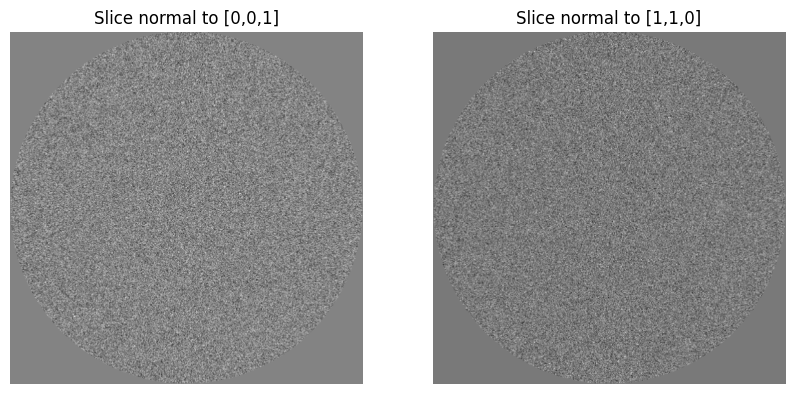

In [14]:
import matplotlib.pyplot as plt
# plot both slices side to side for visual check
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(slices[0,0].cpu(), cmap="gray")
plt.title("Slice normal to [0,0,1]")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(slices[1,0].cpu(), cmap="gray")
plt.title("Slice normal to [1,1,0]")
plt.axis("off")
plt.show()
